In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/anaconda3/envs/zxt_cuda_11.3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the style and content images
style_image = Image.open("./datas/1_origin_data/bamboo_leaf.jpg").convert("RGB")
content_image = Image.open("./datas/2_preprocessed_data/preprocessed_tomatoes_edge.png").convert("RGB")



print(style_image.size)
print(content_image.size)

(32, 32)
(768, 1024)


In [3]:
# Define the image transformations
# Define the image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess the style and content images
style_tensor = transform(style_image).unsqueeze(0).to(device)
content_tensor = transform(content_image).unsqueeze(0).to(device)

print(content_tensor.size())

torch.Size([1, 3, 512, 512])


In [9]:
# Load the pre-trained VGG19 model
model = models.vgg19(pretrained=True).features.to(device).eval()

# Define the content and style layers
content_layers = ["4"]
style_layers = ["1", "2", "3","4", "5"]

# Define the style weights
style_weights = {
    "1": 1.0,
    "2": 0.8,
    "3": 0.5,
    "4": 0.3,
    "5": 0.1
}

# Define the content weight and style weight
content_weight = 1.0
style_weight = 1000.0

# Define the optimizer
optimizer = optim.LBFGS([content_tensor.requires_grad_()])

# Define the style transfer function
def style_transfer(input_tensor):
    def gram_matrix(tensor):
        if tensor.dim() == 2:
            tensor = input_tensor.unsqueeze(0)
        if tensor.dim() > 4:
            tensor = torch.squeeze(tensor, dim=0)

        print(f"in gram_function {tensor.size()}")
        _, c, h, w = tensor.size()
        tensor = tensor.view(c, h * w)
        gram = torch.mm(tensor, tensor.t())
        return gram

    def content_loss(input_features, target_features):
        return torch.mean((input_features - target_features) ** 2)

    def style_loss(input_features, target_features):
        input_gram = gram_matrix(input_features)
        target_gram = gram_matrix(target_features)
        return torch.mean((input_gram - target_gram) ** 2)

    def get_features(tensor, model):
        features = {}
        x = tensor

        # for name, layer in model._modules.items():
        #     print(f"{name},{layer}")

        for name, layer in model._modules.items():
            x = layer(x)
            if name in content_layers:
                features["content"] = x
            if name in style_layers:
                features["style_" + name] = x
        return features

    def compute_loss(input_tensor, content_tensor, style_tensor):
        input_features = get_features(input_tensor, model)
        content_features = get_features(content_tensor, model)
        style_features = get_features(style_tensor, model)

        # print(input_features)
        # print(content_features)
        # print(style_features)

        c_loss = content_weight * content_loss(input_features["content"], content_features["content"])

        s_loss = 0
        for layer in style_layers:
            input_style_features = input_features["style_" + layer]
            target_style_features = style_features["style_" + layer]
            input_style_gram = gram_matrix(input_style_features)
            target_style_gram = gram_matrix(target_style_features)
            s_loss += style_weights[layer] * style_loss(input_style_gram, target_style_gram)

        total_loss = c_loss + style_weight * s_loss
        return total_loss

    def closure():
        optimizer.zero_grad()
        loss = compute_loss(input_tensor, content_tensor, style_tensor)
        loss.backward()
        return loss

    optimizer.step(closure)

# Perform style transfer
input_tensor = torch.randn(content_tensor.size(), device=device, requires_grad=True)
style_transfer(input_tensor)

# Convert the output tensor to an image
output_image = transforms.ToPILImage()(input_tensor.squeeze(0).cpu().detach())

# Save the output image
output_image.save("./datas/3_style_data/after_styled_tomatoes.jpg")


/opt/anaconda3/envs/zxt_cuda_11.3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/anaconda3/envs/zxt_cuda_11.3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


in gram_function torch.Size([1, 64, 512, 512])
in gram_function torch.Size([1, 64, 512, 512])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 64, 512, 512])
in gram_function torch.Size([1, 64, 512, 512])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 64, 512, 512])
in gram_function torch.Size([1, 64, 512, 512])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 64, 256, 256])
in gram_function torch.Size([1, 64, 256, 256])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 128, 256, 256])
in gram_function torch.Size([1, 128, 256, 256])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 3, 512, 512])
in gram_function torch.Size([1, 64, 512, 512])
in gram_function torc

# 将图像上采样到512*512

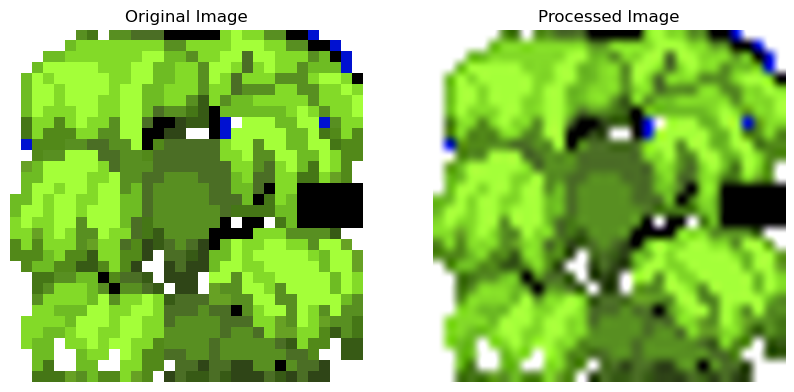

(32, 32)
(512, 512)


In [10]:
import matplotlib.pyplot as plt

# Resize the image
resized_image = style_image.resize((512, 512))

# Display the original and processed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(style_image)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(resized_image)
axes[1].set_title("Processed Image")
axes[1].axis("off")
plt.show()

print(style_image.size)
print(resized_image.size)
resized_image.save(fp="./datas/3_style_data/512.jpg")